In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
import numpy as np
import seaborn as sns
np.random.seed(44)


In [2]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    'figure.figsize': [7,3],
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})
sns.set(rc={'figure.figsize':(7,3)})

# Normal-normal models  in probabilistic programming


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on.. 


*   Chapter 2 of O. Martin, *Bayesian Analysis with Python, Second Edition*.

*  Notebook by G. Corani

#  Inference about the speed of light

* At the end of the 19th century  Newcomb carried out several experiments to determine the speed of light.

* He measured how much  time it took for the light to travel a certain distance.

In [3]:
#Below  the  66 measurements.

data = np.array([248.28, 248.26, 248.33, 248.24, 248.34, 247.56, 248.27, 248.16,
                  248.4, 247.98, 248.29, 248.22, 248.24, 248.21, 248.25, 248.3,
                  248.23, 248.29, 248.31, 248.19, 248.24, 248.2, 248.36, 248.32,
                  248.36, 248.28, 248.25, 248.21, 248.28, 248.29, 248.37, 248.25,
                  248.28, 248.26, 248.3, 248.32, 248.36, 248.26, 248.3, 248.22,
                  248.36, 248.23, 248.27, 248.27, 248.28, 248.27, 248.31, 248.27,
                  248.26, 248.33, 248.26, 248.32, 248.32, 248.24, 248.39, 248.28,
                  248.24, 248.25, 248.32, 248.25, 248.29, 248.27, 248.28, 248.29,
                  248.16, 248.23])


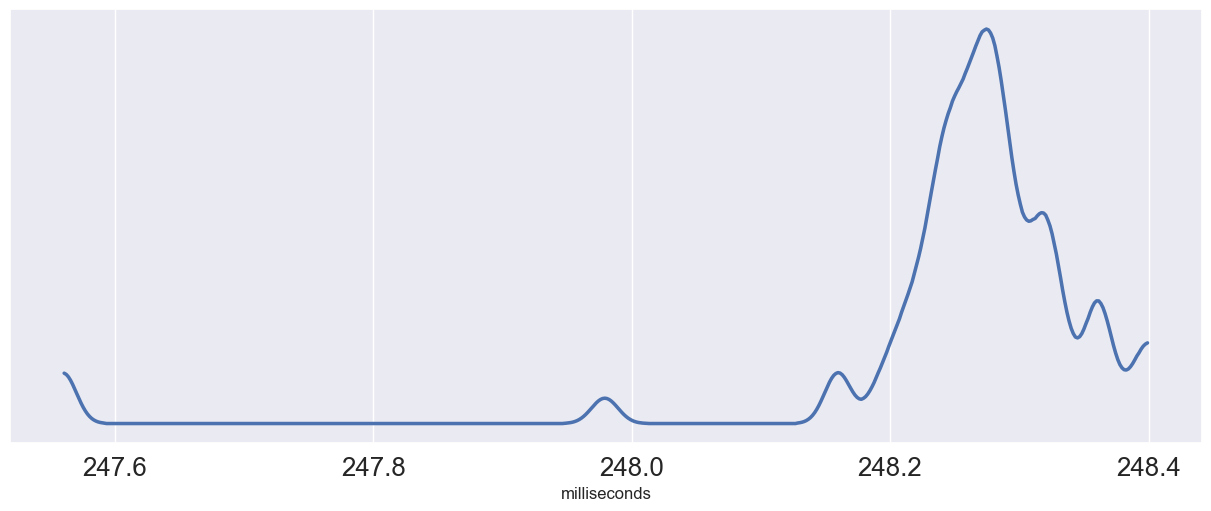

In [4]:
# The data are almost  normally distributed, apart from some  low-values outliers  which are far from the mean.
#the density plot is called kde (kernel density estimation)
az.plot_kde(data, figsize=[12,5])
plt.yticks([])
plt.xlabel('milliseconds');

# Normal - normal model


\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu})  && \text{prior uncertainty on } \mu\\
\sigma & \sim \text{HalfNormal} (\sigma_{\sigma}) &&  \text{prior uncertainty on } \sigma\\
y & \sim N(\mu, \sigma) && \text{distribution of the data given } \mu \text{ and } \sigma \\
\end{align*}

* The observations are assumed to be independent.


In [5]:
# Implementation with  informative priors 

with pm.Model() as model_newcomb:
    #prior for the location of mu
    # Based on prior information,  mu should lie within the interval (120,  360).
    # This corresponds to a normal distribution with mu = 240, sigma = 60
    mu = pm.Normal('mu', 240, 60)
    
    #Based on prior information, a plausible value for the standard deviation of the noise is 2.
    # This is roughly the median value of the halfnormal distribution with scale set to 3.
    sigma = pm.HalfNormal('sigma', sd=3)

    
    #likelihood. Each observation is a sample from N(mu, sigma).
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    
    trace_newcomb = pm.sample( return_inferencedata= True )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


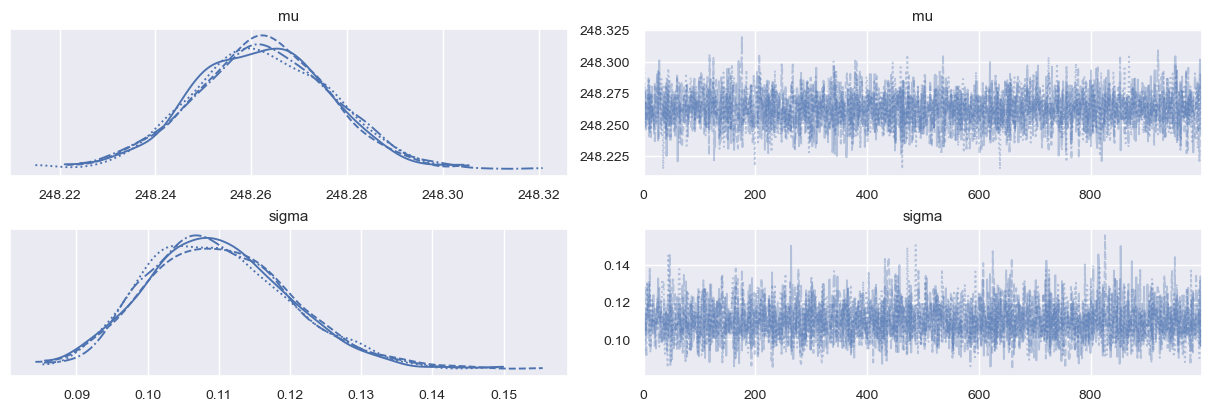

In [6]:
# The  density plots of  both parameters are smooth and the chains are well-mixing.

with  model_newcomb:
    az.plot_trace(trace_newcomb);

# What if we change the prior?

In [7]:
with pm.Model() as model_newcomb_2:

    #mu = pm.Normal('mu', 240, 60)
    #we assume to have  different prior information  about mu; larger mean and larger uncertainty.
    mu = pm.Normal('mu', 300, 100)
    
    #identical to the previous model
    sigma = pm.HalfNormal('sigma', sd=3)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    
    trace_newcomb_2 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [8]:
# The posterior is practically identical under the two different priors.
# This is  good: the data are strong enough to converge to the same posterior.
# The likelihood overwhelms the prior; the results are thus robust to the specification of the prior.


a = az.summary(trace_newcomb) 
b = az.summary(trace_newcomb_2) 
pd.concat([a,b])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,248.262,0.014,248.236,248.288,0.0,0.0,3133.0,2791.0,1.0
sigma,0.110,0.010,0.092,0.129,0.0,0.0,3375.0,2557.0,1.0
mu,248.262,0.014,248.236,248.288,0.0,0.0,3443.0,2639.0,1.0
sigma,0.109,0.010,0.093,0.128,0.0,0.0,3674.0,2567.0,1.0


# Posterior *point* prediction 

* Make a prediction about the next measurement.  


* The simplest answer is to use the posterior mean (248.262 as in the previous slide).


* Yet  the *point* prediction ignores the uncertainty due to:

    *  the noise
    * our uncertainty in the value $\mu$ and  $\sigma$, related to their posterior variance.

# Posterior probabilistic prediction

* The trace contains some thousands (e.g., 4000) parameter samples. Each sample contains both a value of $\mu$ and $\sigma$. 


* We denote a generic sample as  $<\mu_s, \sigma_s >$. 


* This is a numerical approximation of the posterior density of $\mu$ and $\sigma$.


* The probabilistic prediction for the next observation is computed  by simulating a measurement prediction for each parameter set:

$$
Y^{\text{new}}_{s} \; \sim \; N\left(\mu_s, \sigma_s\right)\;\; s=1,2...4000$$



# Posterior probabilistic prediction

* Each parameter sample  $<\mu_s, \sigma_s >$  yields a different prediction:

$$
\left[
\begin{array}{ll} 
\mu_1 &   \sigma_1 \\
\mu_2 & \sigma_2 \\
\vdots & \vdots  \\
\mu_{4000}  & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
y^{\text{new}}_{1} \\
y^{\text{new}}_{2} \\
\vdots \\
y^{\text{new}}_{4000} \\
\end{array}
\right]
$$

The resulting collection of 4,000 predictions $Y_{\text{new}}$ approximates the posterior prediction for a new measurement, accounting for two sources of uncertainty:

   * uncertainty in the estimation of $\mu, \sigma$
   * uncertainty in the realization of the noise.

In [9]:
# We compute the posterior prediction by adding a single line to our pymc3 code.
# We could obtain the same result by working with the  samples from the trace.


with pm.Model() as model_newcomb_with_pred:
    #model as before (first variant)
    mu = pm.Normal('mu', 240, 80)
    sigma = pm.HalfNormal('sigma', sd=3)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    
    #prediction
    prediction = pm.Normal('prediction', mu=mu, sd=sigma)
        
    trace_newcomb_with_pred = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prediction, sigma, mu]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [10]:
az.summary(trace_newcomb_with_pred, var_names='prediction')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prediction,248.262,0.111,248.055,248.473,0.002,0.001,4966.0,2983.0,1.0


# Using the posterior prediction for  Posterior Predictive Checks (ppc)


* Even if the sampling  has converged correctly, the model might be inadequate.

* Posterior predictive check (PPC) is a way to check that the model adequately fits the data.

* Idea: 
    * makes posterior probabilistic predictions via sampling  as already shown;
    * verify that the distribution of the simulated data  resembles the distribution of the actual data.
    
* There are specialized functions for this.


# Posterior predictive checks

* We  need  less samples for computing PPC relative to the MCMC sample.
 
The  `sample_posterior_predictive` function receives as parameter the number $n$ of desired samples and then: 

1. it randomly choose $n$ samples of type $< \mu_s, \sigma_s>$ from the trace;
2. it generates synthetic observations as discussed.

* Eventually we need to check that the sampled observations follow a distribution similar to the observed data.




In [11]:
with model_newcomb:
    # select 500 samples <mu_s ,sigma_s> from the trace
    # for each samples, compute a draw N(mu_s ,sigma_s) 
    # The ppc variable is a dictionary, with the keys being the name of the observed variable in our model and the values an array of shape (samples, size). 
    # The dictionary allows dealing with models with more than one observed variable. 
    ppc = pm.sample_posterior_predictive(trace_newcomb, samples=500)

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


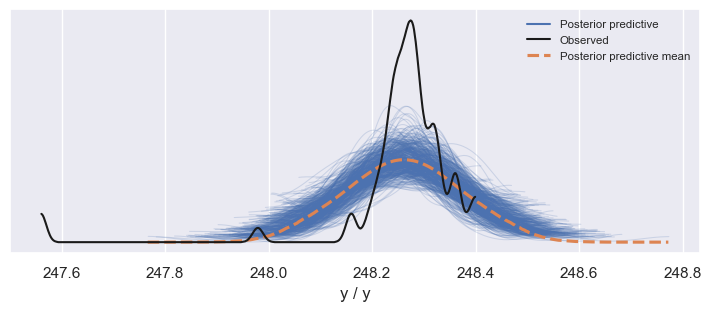

In [12]:
# The density related to each mu_s and sigma_s is shown. The average density is also shown.
# The density reproduced by the model is too low around the center.
# That is becaude the  variance is thus too large, in order to assign some probability also to the outliers. 
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model_newcomb));

#  Robust models

* Outliers are too far from the mean  for the normal model. 

* These points could be due to experimental errors. If we are sure that this is the case,  we could remove them from our dataset (leaving a record of the removal and the reasons why we did it). 

* A more principled approach option is to adopt a likelihood which is *robust* to outliers.

#  The normal distribution has light tails

* The normal distribution is  sensitive to outliers. 


* The probability of finding a value falls rapidly as we move away from the mean; it is practically 0 when we are more than 3 standard deviation from the mean.


* If the data contains observations which are even further from the mean, the normal distribution is not a good model. 


* Probability of lying *outside* the interval $[ \mu - k \sigma, \mu + k \sigma]$:

| k |   \begin{equation} P \end{equation}|
|:-:|-:-|
| 1 |  0.3173 |
| 2 | 0.0455  |
| 3 | 0.0026 |
| 4 | 0.00006 |

# Student's t distribution


<img src='img/Student_t.png' width=400 align="center" > 

* It is defined by a mean, a scale $\sigma$ (related to the spread of the distribution) and by $\nu$ (referred to as *degrees of freedom*  or as *normality* coefficient).

*  $\nu$ controls how _heavy_ the tails of the distribution are. 

    *  $\nu > 30$: the Student is practically equivalent to a Gaussian. 

    * $\nu = 4$ is a common choice to have a robust model with heavy tails, which can model observations that are far away from the mean.

# Discussion

* The Student probability density decays as a polynomial function of the squared distance from the center, as opposed to an exponential function in the Gaussian case.


* So there is more probability mass in the tail compared  with a Gaussian distribution. 


* The Student distribution has *heavy* tails, which makes it robust to outliers.


* For $\nu$  ≫ 5, the Student distribution rapidly approaches a Gaussian distribution and loses its robustness properties.


* The numerical procedure of the Student likelihood is equivalent to assigning a weight to each data point; data point with a large residual are given low weight in the estimation.

# Comparing the normal and the Student-t distribution


* Probability of lying *outside* the interval $(\mu - k \sigma, \mu + k \sigma)$:


| k |   Normal | Student ($\nu$=4)
|:-:|-:-|-:-|    
    | 1 |  0.32 | 0.38    |
    | 2 | 0.04 |  0.12 | 
    | 3 | 0.002 | 0.04 |
    | 4 | 0.00006 | 0.02 |
    
* The 99% interval is:

    * $\mu \pm 2.58 \sigma$ for the normal distribution;
   
    * $\mu \pm 4.61 \sigma$ for the Student-t distribution ($\nu$=4)

# Robust probabilistic model

\begin{align*}
\mu &\sim N(\mu', \sigma_{\mu}) && \text{prior beliefs about } \mu\\ 
\sigma &\sim \text{Half-Normal}(\sigma_{\sigma}) && \text{prior beliefs about } \sigma \\
y & \sim StudentT (\mu, \sigma, \nu=4) && \text{robust model of the observations} 
\end{align*}

In [13]:
with pm.Model() as model_t:
    #the priors are the same as those of  the first variant
    mu_t      = pm.Normal('mu_t', 240, 80)
    sigma_t = pm.HalfNormal('sigma_t', sd=3)

    #robust likelihood
    y              = pm.StudentT('y', mu=mu_t, sd=sigma_t, nu=4, observed=data)

    #prediction for a new measurement
    #prediction = pm.StudentT('prediction', mu=mu_t, sd=sigma_t, nu=4)
        
    trace_t = pm.sample() 

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_t, mu_t]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [14]:
# The estimate of $\mu$ is practically identical in the two cases.
# But the Student model  estimates a much lower  $\sigma$ than the normal model. 
# The t- distribution gives less weight (being less surprised) to values away from the mean; thus it avoids inflating  the  variance.
#  This allows keeping higher the density around the bulk of the data, as shown by the posterior predictive check.

# Let us compare the estimates of the two models
with model_t:
    summary_t = az.summary(trace_t)
with model_newcomb:
    summary= az.summary(trace_newcomb)
pd.concat([summary, summary_t])[ ["mean","sd" ]]

,mean,sd
mu,248.262,0.014
sigma,0.110,0.010
mu_t,248.275,0.007
sigma_t,0.047,0.006


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


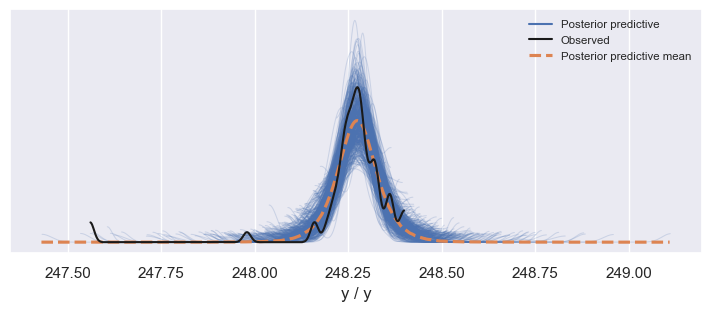

In [15]:
with model_t:
    ppc_t = pm.sample_posterior_predictive(trace_t, samples=500)
    
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_t, model=model_t));

# Classroom activity

* Anonimously, each  student writes his own height within a shared spreadsheet (link provided by the teacher)

* Define a probabilistic model for the distribution of height  and implement it in PyMC3.




* Fit the model on the provided data:

    * how is your  posterior different from your prior? 

    * how is your  posterior different from that of other students? 

# Further exercises


* The Gaussian is a distribution _without limits_ that is, it is valid in the interval $[-\infty, \infty]$, in the previous example we use it to model data that we know have limits. What do you think of this choice?


* Using the speed of light data, calculate the mean and standard deviation with and without the _outliers_, compare those values ​​with those obtained with the gaussian and the robust model.


* Is it beneficial to adopt a robust likelihood to analyze the data?